# CORAL Step-by-Step Tutorial: Saccharomyces Example

This tutorial demonstrates how to use CORAL components individually,
running each step separately with the Saccharomyces species example.

All outputs will be written to `../test_output/step_by_step_tutorial/`

## Overview

This tutorial walks through each component of the CORAL pipeline:
1. Download Genomes
2. Index Reference Genome
3. Generate Simulated Reads
4. Align Reads to Reference
5. Generate Multi-Taxa Pileup
6. Extract Mutations
7. Normalize Mutation Counts
8. Generate Visualizations

Each step can be run independently, allowing you to understand and customize the workflow.


## Setup and Configuration

First, import the necessary modules and configure the pipeline parameters.


In [ ]:
import os
from coral.genome_manager import Genome
from coral.alignment_manager import Aligner
from coral.pileup_manager import Pileup
from coral.mutation_extractor_manager import MutationExtractor, FiveMerExtractor, MutationNormalizer
from coral.plot_utils import MutationSpectraPlotter, CoveragePlotter, MutationDensityPlotter
from coral.utils import get_top_n_chromosomes, log


In [2]:
# Configuration
BASE_OUTPUT_DIR = "../test_output/step_by_step_tutorial"

# Species configuration (Saccharomyces example)
OUTGROUP = ("Saccharomyces_mikatae_IFO_1815", "GCF_947241705.1")
SPECIES1 = ("Saccharomyces_paradoxus", "GCF_002079055.1")
SPECIES2 = ("Saccharomyces_cerevisiae_S288C", "GCF_000146045.2")

# Pipeline parameters
MAPQ = 60
CORES = None  # Use all available cores
VERBOSE = True

# Create output directory
os.makedirs(BASE_OUTPUT_DIR, exist_ok=True)

print("Configuration:")
print(f"  Output directory: {BASE_OUTPUT_DIR}")
print(f"  Reference (outgroup): {OUTGROUP[0]}")
print(f"  Species 1: {SPECIES1[0]}")
print(f"  Species 2: {SPECIES2[0]}")
print(f"  MAPQ threshold: {MAPQ}")


Configuration:
  Output directory: ../test_output/step_by_step_tutorial
  Reference (outgroup): Saccharomyces_mikatae_IFO_1815
  Species 1: Saccharomyces_paradoxus
  Species 2: Saccharomyces_cerevisiae_S288C
  MAPQ threshold: 60


## Step 1: Download Genomes

This step downloads genomes from NCBI using the datasets CLI.
Each genome is saved as a FASTA file in the output directory.


In [ ]:
# Download reference genome (outgroup)
print(f"Downloading reference genome: {OUTGROUP[0]} ({OUTGROUP[1]})")
reference = Genome(
    name=OUTGROUP[0],
    accession=OUTGROUP[1],
    output_dir=BASE_OUTPUT_DIR,
    no_cache=False,  # Use cache if genome already downloaded
    verbose=VERBOSE
)
reference.download()
print(f"✓ Reference genome downloaded: {reference.fasta_path}")


In [ ]:
# Download species 1
print(f"Downloading species 1: {SPECIES1[0]} ({SPECIES1[1]})")
genome1 = Genome(
    name=SPECIES1[0],
    accession=SPECIES1[1],
    output_dir=BASE_OUTPUT_DIR,
    no_cache=False,
    verbose=VERBOSE
)
genome1.download()
print(f"✓ Species 1 genome downloaded: {genome1.fasta_path}")


In [ ]:
# Download species 2
print(f"Downloading species 2: {SPECIES2[0]} ({SPECIES2[1]})")
genome2 = Genome(
    name=SPECIES2[0],
    accession=SPECIES2[1],
    output_dir=BASE_OUTPUT_DIR,
    no_cache=False,
    verbose=VERBOSE
)
genome2.download()
print(f"✓ Species 2 genome downloaded: {genome2.fasta_path}")


## Step 2: Index Reference Genome

This step creates BWA index files for the reference genome.
Indexing is required before alignment can proceed.


In [6]:
reference.index(aligner='bwa')
print(f"✓ Reference genome indexed for BWA alignment")
print(f"  Index files created:")
print(f"    - {reference.fasta_path}.amb")
print(f"    - {reference.fasta_path}.ann")
print(f"    - {reference.fasta_path}.bwt")
print(f"    - {reference.fasta_path}.pac")
print(f"    - {reference.fasta_path}.sa")
print(f"    - {reference.fasta_path}.fai (samtools index)")


Indexing genome for Saccharomyces_mikatae_IFO_1815 with bwa...
Running: bwa index ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815/Saccharomyces_mikatae_IFO_1815.fasta


[bwa_index] Pack FASTA... 0.09 sec
[bwa_index] Construct BWT for the packed sequence...
[bwa_index] 5.07 seconds elapse.
[bwa_index] Update BWT... 0.08 sec
[bwa_index] Pack forward-only FASTA... 0.04 sec
[bwa_index] Construct SA from BWT and Occ... 

Running: samtools faidx ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815/Saccharomyces_mikatae_IFO_1815.fasta
Indexing complete for Saccharomyces_mikatae_IFO_1815
✓ Reference genome indexed for BWA alignment
  Index files created:
    - ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815/Saccharomyces_mikatae_IFO_1815.fasta.amb
    - ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815/Saccharomyces_mikatae_IFO_1815.fasta.ann
    - ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815/Saccharomyces_mikatae_IFO_1815.fasta.bwt
    - ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815/Saccharomyces_mikatae_IFO_1815.fasta.pac
    - ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815/Saccharomyces_mikatae_IFO_1815.fasta.sa
    - ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815/Saccharomyces_mikatae_IFO_1815.fasta.fai (samtools index)


3.26 sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa index ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815/Saccharomyces_mikatae_IFO_1815.fasta
[main] Real time: 8.624 sec; CPU: 8.538 sec


## Step 3: Generate Simulated Reads

This step simulates short reads by sliding a window across each genome.
Reads are saved as FASTQ files and will be aligned to the reference.


In [7]:
# Generate reads for species 1
print(f"Generating simulated reads for {SPECIES1[0]}...")
genome1.generate_fragment_fastq(
    length=150,  # Read length
    offset=75,   # Sliding window offset
    force=False  # Use cache if exists
)
print(f"✓ Reads generated: {genome1.fastq_path}")


Generating simulated reads for Saccharomyces_paradoxus...
Wrote ../test_output/step_by_step_tutorial/Saccharomyces_paradoxus/Saccharomyces_paradoxus.fastq
✓ Reads generated: ../test_output/step_by_step_tutorial/Saccharomyces_paradoxus/Saccharomyces_paradoxus.fastq


In [8]:
# Generate reads for species 2
print(f"Generating simulated reads for {SPECIES2[0]}...")
genome2.generate_fragment_fastq(
    length=150,
    offset=75,
    force=False
)
print(f"✓ Reads generated: {genome2.fastq_path}")


Generating simulated reads for Saccharomyces_cerevisiae_S288C...
Wrote ../test_output/step_by_step_tutorial/Saccharomyces_cerevisiae_S288C/Saccharomyces_cerevisiae_S288C.fastq
✓ Reads generated: ../test_output/step_by_step_tutorial/Saccharomyces_cerevisiae_S288C/Saccharomyces_cerevisiae_S288C.fastq


## Step 4: Align Reads to Reference

This step aligns simulated reads to the reference genome using BWA.
Alignments are filtered by MAPQ and saved as BAM files.


Aligning Saccharomyces_paradoxus reads to reference...
Running alignment to raw BAM...
Running: bwa mem -t 16 ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815/Saccharomyces_mikatae_IFO_1815.fasta ../test_output/step_by_step_tutorial/Saccharomyces_paradoxus/Saccharomyces_paradoxus.fastq | samtools view -bS - > ../test_output/step_by_step_tutorial/BAMs/Saccharomyces_paradoxus_to_Saccharomyces_mikatae_IFO_1815_raw.bam.tmp


[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 161229 sequences (24184350 bp)...
[M::mem_process_seqs] Processed 161229 reads in 77.443 CPU sec, 4.918 real sec


Filtering from raw BAM to final BAM...


[main] Version: 0.7.17-r1188
[main] CMD: bwa mem -t 16 ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815/Saccharomyces_mikatae_IFO_1815.fasta ../test_output/step_by_step_tutorial/Saccharomyces_paradoxus/Saccharomyces_paradoxus.fastq
[main] Real time: 5.799 sec; CPU: 77.702 sec


Filter Summary:
  Total reads processed:   161632
  Reads kept:              78583
  Filtered (poor mapping):     75275
  Filtered (low MAPQ):     4374
  Filtered (disjoint):     3398
  Filtered (alt contigs):  0
MAPQ histogram saved to ../test_output/step_by_step_tutorial/Plots/Saccharomyces_paradoxus_to_Saccharomyces_mikatae_IFO_1815.png
Running: samtools index -c ../test_output/step_by_step_tutorial/BAMs/Saccharomyces_paradoxus_to_Saccharomyces_mikatae_IFO_1815.bam


[bam_sort_core] merging from 0 files and 16 in-memory blocks...


Finished (disk-cached): ../test_output/step_by_step_tutorial/BAMs/Saccharomyces_paradoxus_to_Saccharomyces_mikatae_IFO_1815.bam
✓ Alignment complete: ../test_output/step_by_step_tutorial/BAMs/Saccharomyces_paradoxus_to_Saccharomyces_mikatae_IFO_1815.bam


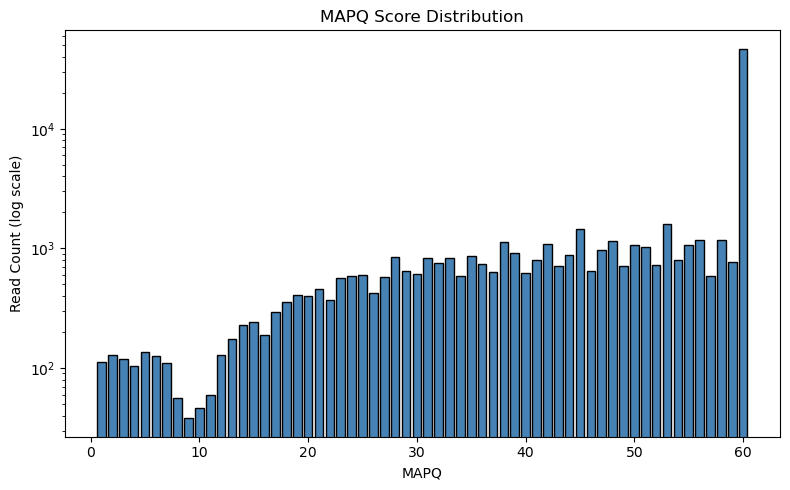

In [9]:
# Align species 1
print(f"Aligning {SPECIES1[0]} reads to reference...")
aligner1 = Aligner(
    species_genome=genome1,
    reference_genome=reference,
    base_output_dir=BASE_OUTPUT_DIR,
    aligner_name="bwa",
    aligner_cmd=None,  # Use default BWA command
    cores=CORES,
    verbose=VERBOSE
)
aligner1.align_disk_cached(
    mapq=MAPQ,
    low_mapq=1,
    continuity=True
)
print(f"✓ Alignment complete: {aligner1.final_bam}")


Aligning Saccharomyces_cerevisiae_S288C reads to reference...
Running alignment to raw BAM...
Running: bwa mem -t 16 ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815/Saccharomyces_mikatae_IFO_1815.fasta ../test_output/step_by_step_tutorial/Saccharomyces_cerevisiae_S288C/Saccharomyces_cerevisiae_S288C.fastq | samtools view -bS - > ../test_output/step_by_step_tutorial/BAMs/Saccharomyces_cerevisiae_S288C_to_Saccharomyces_mikatae_IFO_1815_raw.bam.tmp


[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 162084 sequences (24312600 bp)...
[M::mem_process_seqs] Processed 162084 reads in 75.444 CPU sec, 4.819 real sec


Filtering from raw BAM to final BAM...


[main] Version: 0.7.17-r1188
[main] CMD: bwa mem -t 16 ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815/Saccharomyces_mikatae_IFO_1815.fasta ../test_output/step_by_step_tutorial/Saccharomyces_cerevisiae_S288C/Saccharomyces_cerevisiae_S288C.fastq
[main] Real time: 5.591 sec; CPU: 75.709 sec


Filter Summary:
  Total reads processed:   162373
  Reads kept:              65617
  Filtered (poor mapping):     86676
  Filtered (low MAPQ):     6209
  Filtered (disjoint):     3869
  Filtered (alt contigs):  0
MAPQ histogram saved to ../test_output/step_by_step_tutorial/Plots/Saccharomyces_cerevisiae_S288C_to_Saccharomyces_mikatae_IFO_1815.png
Running: samtools index -c ../test_output/step_by_step_tutorial/BAMs/Saccharomyces_cerevisiae_S288C_to_Saccharomyces_mikatae_IFO_1815.bam
Finished (disk-cached): ../test_output/step_by_step_tutorial/BAMs/Saccharomyces_cerevisiae_S288C_to_Saccharomyces_mikatae_IFO_1815.bam
✓ Alignment complete: ../test_output/step_by_step_tutorial/BAMs/Saccharomyces_cerevisiae_S288C_to_Saccharomyces_mikatae_IFO_1815.bam


[bam_sort_core] merging from 0 files and 16 in-memory blocks...


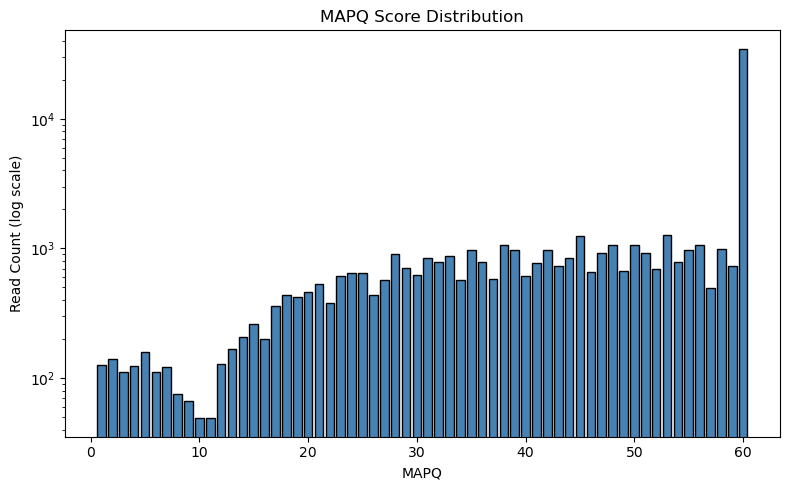

In [10]:
# Align species 2
print(f"Aligning {SPECIES2[0]} reads to reference...")
aligner2 = Aligner(
    species_genome=genome2,
    reference_genome=reference,
    base_output_dir=BASE_OUTPUT_DIR,
    aligner_name="bwa",
    aligner_cmd=None,
    cores=CORES,
    verbose=VERBOSE
)
aligner2.align_disk_cached(
    mapq=MAPQ,
    low_mapq=1,
    continuity=True
)
print(f"✓ Alignment complete: {aligner2.final_bam}")


## Step 5: Generate Multi-Taxa Pileup

This step generates a pileup file containing base calls from
the reference and all aligned species at each position.


In [11]:
run_id = f"{OUTGROUP[0]}__{SPECIES1[0]}__{SPECIES2[0]}"

pileup = Pileup(
    outgroup=reference,
    aligners=[aligner1, aligner2],
    base_output_dir=BASE_OUTPUT_DIR,
    run_id=run_id,
    no_cache=False,
    verbose=VERBOSE
)

pileup_path = pileup.generate()
print(f"✓ Pileup generated: {pileup_path}")
print("  The pileup file contains:")
print("    - Reference base calls")
print("    - Base calls from all aligned species")
print("    - Coverage information at each position")


Generating pileup: ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815__Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C.pileup.gz


[mpileup] 2 samples in 2 input files


Pileup written to: ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815__Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C.pileup.gz
✓ Pileup generated: ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815__Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C.pileup.gz
  The pileup file contains:
    - Reference base calls
    - Base calls from all aligned species
    - Coverage information at each position


## Step 6: Extract Mutations

This step identifies unambiguous triplet mutations where:
- All species share the same flanking bases
- One species differs at the central position


In [12]:
mutations_dir = os.path.join(BASE_OUTPUT_DIR, run_id, 'Mutations')
triplets_dir = os.path.join(BASE_OUTPUT_DIR, run_id, 'Triplets')
os.makedirs(mutations_dir, exist_ok=True)
os.makedirs(triplets_dir, exist_ok=True)

# Extract full mutations
print("Extracting triplet mutations...")
mutation_extractor = MutationExtractor(
    reference=reference.name,
    taxon1=genome1.name,
    taxon2=genome2.name,
    pileup_file=pileup_path,
    mutation_output_dir=mutations_dir,
    triplet_output_dir=triplets_dir,
    no_full_mutations=False,
    no_cache=False,
    verbose=VERBOSE
)
mutation_extractor.extract()
print(f"✓ Mutations extracted")
print(f"  Output files in {mutations_dir}:")
print(f"    - *_mutations.csv.gz (full mutation list)")
print(f"    - *_mutations.json (mutation context counts)")


Extracting triplet mutations...
Saved mutation counts to ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815__Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C/Mutations/Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C__Saccharomyces_mikatae_IFO_1815__mutations.json and ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815__Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C/Mutations/Saccharomyces_cerevisiae_S288C__Saccharomyces_paradoxus__Saccharomyces_mikatae_IFO_1815__mutations.json
Saved triplet counts to ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815__Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C/Triplets/Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C__Saccharomyces_mikatae_IFO_1815__triplets.json and ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815__Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C/Triplets/Saccharomyces_cerevisiae_S288C__Saccharomyces_paradoxus__Sacch

In [ ]:
# Extract 5-mer mutations (for spectra)
print("Extracting 5-mer mutations for mutation spectra...")
fivemer_extractor = FiveMerExtractor(
    reference=reference.name,
    taxon1=genome1.name,
    taxon2=genome2.name,
    pileup_file=pileup_path,
    output_dir=mutations_dir,
    no_cache=False,
    verbose=VERBOSE
)
fivemer_extractor.extract()
print(f"✓ 5-mer mutations extracted")


## Step 7: Normalize Mutation Counts

This step normalizes mutation counts by underlying trinucleotide
abundance and generates collapsed mutation spectra.


In [13]:
tables_dir = os.path.join(BASE_OUTPUT_DIR, run_id, "Tables")
os.makedirs(tables_dir, exist_ok=True)

normalizer = MutationNormalizer(
    input_dir=os.path.join(BASE_OUTPUT_DIR, run_id),
    output_dir=tables_dir,
    verbose=VERBOSE,
    divergence_time=None  # Optional: provide divergence time for rate calculation
)
normalizer.normalize()
print(f"✓ Mutations normalized")
print(f"  Output files in {tables_dir}:")
print(f"    - normalized_scaled.tsv (normalized mutation spectra)")
print(f"    - collapsed_mutations.tsv (raw mutation counts)")
print(f"    - scaled_raw.tsv (scaled raw counts)")
print(f"    - triplets.tsv (trinucleotide context counts)")


Mutations per triplet from divergence:
Saccharomyces_cerevisiae_S288C: 4.87e-02
Saccharomyces_paradoxus: 3.78e-02
✓ Mutations normalized
  Output files in ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815__Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C/Tables:
    - normalized_scaled.tsv (normalized mutation spectra)
    - collapsed_mutations.tsv (raw mutation counts)
    - scaled_raw.tsv (scaled raw counts)
    - triplets.tsv (trinucleotide context counts)


## Step 7.5: Extract Intervals

This step extracts read intervals from BAM files for coverage visualization.
Intervals represent the genomic regions covered by aligned reads.


In [16]:
# Extract intervals from BAM files (required for coverage plotting)
from coral.pipeline import MutationExtractionPipeline

intervals_dir = os.path.join(BASE_OUTPUT_DIR, run_id, 'Intervals')
os.makedirs(intervals_dir, exist_ok=True)

print("Extracting intervals from BAM files...")
# Create a minimal pipeline instance to use its interval extraction method
temp_pipeline = MutationExtractionPipeline(
    species_list=[SPECIES1, SPECIES2],
    outgroup=OUTGROUP,
    base_output_dir=BASE_OUTPUT_DIR,
    run_id=run_id,
    verbose=VERBOSE
)
temp_pipeline.alignments = [aligner1, aligner2]

# Extract intervals using the pipeline's method
temp_pipeline.extract_intervals()
print(f"✓ Intervals extracted to {intervals_dir}")


Extracting intervals from BAM files...
Intervals written to: ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815__Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C/Intervals/Saccharomyces_paradoxus_to_Saccharomyces_mikatae_IFO_1815_intervals.tsv.gz
Intervals written to: ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815__Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C/Intervals/Saccharomyces_cerevisiae_S288C_to_Saccharomyces_mikatae_IFO_1815_intervals.tsv.gz
✓ Intervals extracted to ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815__Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C/Intervals


## Step 8: Generate Visualizations

This step generates mutation spectra plots and genomic visualizations.


In [17]:
plots_dir = os.path.join(BASE_OUTPUT_DIR, run_id, "Plots")
os.makedirs(plots_dir, exist_ok=True)

# Mutation spectra plots
print("Generating mutation spectra plots...")
spectra_plotter = MutationSpectraPlotter()
spectra_plotter.plot(tables_dir=tables_dir, output_dir=plots_dir, verbose=VERBOSE)
print(f"✓ Mutation spectra plots generated in {plots_dir}")


Generating mutation spectra plots...
[plot_runner] Loading mutation summary tables...
[plot_runner] Plotting normalized mutations for Saccharomyces_cerevisiae_S288C__Saccharomyces_paradoxus__Saccharomyces_mikatae_IFO_1815__mutations
[plot_runner] Plotting normalized mutations for Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C__Saccharomyces_mikatae_IFO_1815__mutations
[plot_runner] Plotting raw mutations for Saccharomyces_cerevisiae_S288C__Saccharomyces_paradoxus__Saccharomyces_mikatae_IFO_1815__mutations
[plot_runner] Plotting raw mutations for Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C__Saccharomyces_mikatae_IFO_1815__mutations
[plot_runner] Plotting triplet counts for Saccharomyces_cerevisiae_S288C__Saccharomyces_paradoxus__Saccharomyces_mikatae_IFO_1815__mutations
[plot_runner] Plotting triplet counts for Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C__Saccharomyces_mikatae_IFO_1815__mutations
[plot_runner] Plotting overlay for normalized spectra: Sac

In [18]:
# Coverage and mutation density plots (for top chromosomes)
fai_file = reference.fasta_path + '.fai'
if os.path.exists(fai_file):
    print("Generating coverage and mutation density plots...")
    coverage_plotter = CoveragePlotter(fai_file=fai_file, verbose=VERBOSE)
    mutation_density_plotter = MutationDensityPlotter(fai_file=fai_file, verbose=VERBOSE)
    
    top_chroms = get_top_n_chromosomes(fai_file, n=3)
    print(f"  Plotting for top 3 chromosomes: {', '.join(top_chroms)}")
    
    intervals_dir = os.path.join(BASE_OUTPUT_DIR, run_id, 'Intervals')
    for chrom in top_chroms:
        print(f"  Plotting {chrom}...")
        coverage_plotter.plot(
            interval_dir=intervals_dir,
            chromosome=chrom,
            output_dir=os.path.join(plots_dir, f"coverage_{chrom}.png")
        )
        mutation_density_plotter.plot(
            mutation_dir=mutations_dir,
            chromosome=chrom,
            output_dir=plots_dir
        )
    print(f"✓ Coverage and mutation density plots generated")


Generating coverage and mutation density plots...
  Plotting for top 3 chromosomes: NC_079259.1, NC_079267.1, NC_079270.1
  Plotting NC_079259.1...
Saved coverage plot: ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815__Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C/Plots/coverage_NC_079259.1.png
Saved mutation density plot: ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815__Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C/Plots/mutation_density_NC_079259.1.png
  Plotting NC_079267.1...
Saved coverage plot: ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815__Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C/Plots/coverage_NC_079267.1.png
Saved mutation density plot: ../test_output/step_by_step_tutorial/Saccharomyces_mikatae_IFO_1815__Saccharomyces_paradoxus__Saccharomyces_cerevisiae_S288C/Plots/mutation_density_NC_079267.1.png
  Plotting NC_079270.1...
Saved coverage plot: ../test_output/step_by_step_tutorial/Sa

## Summary

All outputs are in the output directory. The structure is:

```
step_by_step_tutorial/
  ├── [run_id]/
  │   ├── *.fasta (genome files)
  │   ├── *.pileup.gz (multi-taxa pileup)
  │   ├── Mutations/ (mutation files)
  │   ├── Triplets/ (trinucleotide context files)
  │   ├── Tables/ (normalized spectra)
  │   └── Plots/ (visualizations)
```

**Next steps:**
- Examine mutation spectra in `Tables/normalized_scaled.tsv`
- View plots in `Plots/` directory
- Analyze mutation patterns across the genome

**Note:** This step-by-step tutorial demonstrates each component individually.
For production use, you can use the full pipeline via CLI (`coral run_single`)
or the Python library (`MutationExtractionPipeline`) which runs all steps automatically.
